In [42]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

# data visualization and missing values
import matplotlib.pyplot as plt

# stats
from statsmodels.distributions.empirical_distribution import ECDF

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score 


#设置jupyter显示多行结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'#默认为'last

## 1 数据读取

In [43]:
data=pd.read_csv("carPrice_Assignment.csv",na_values = '?')
#打印数据维度
print("Data set size:", data.shape)
print(data.info())
data.head()

Data set size: (205, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        2

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## 2 数据清洗

### 2-1 处理车辆种类

In [44]:
print('车辆种类种数:', data['CarName'].unique().size)
# 按照车辆品牌分类
data['CarCompany']= data['CarName'].str.split(' ',expand=True)[0] 
data['CarCompany'].unique()
# 修正拼写问题
data['CarCompany'] = data['CarCompany'].replace({'alfa-romero':'alfa-romeo','maxda':'mazda', 'Nissan':'nissan',
'porschce':'porsche','toyouta':'toyota','vokswagen':'volkswagen','vw':'volkswagen'})
data['CarCompany'].unique()

车辆种类种数: 147


array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

array(['alfa-romeo', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'porcshce', 'renault',
       'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [45]:
# 去除car_ID列
data.drop(['car_ID'], axis=1, inplace=True)

#整理出数值型特征和类别型特征
all_cols = data.columns.tolist()
numerical_cols = []
categorical_cols = []

for col in all_cols:
    if (data[col].dtype != 'object') :
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

print('数值型变量数目为：',len(numerical_cols))
print('类别型变量数目为：',len(categorical_cols))

数值型变量数目为： 15
类别型变量数目为： 11


In [46]:
#寻找数值变量中实际应该为类别变量的特征（即并不连续分布）
# transform_cols = []
# for col in numerical_cols:
#     if len(data[col].unique()) < 20:
#         transform_cols.append(col)
# transform_cols
# categorical_cols.append('symboling')
# numerical_cols.remove('symboling')
# data['symboling'] = data['symboling'].astype(str) #更改数据类型

In [47]:
features = data
features.columns
#查看【类别型】特征的唯一值分布情况
features[categorical_cols].describe(include='O').T # 'O' 来获取非数值列的统计信息
#对于类别型特征变量中，单个类型占比超过98％以上的特征进行删除.
freq_ = features[categorical_cols].describe(include='O').T.freq
drop_cols = []
for index,num in enumerate(freq_):
    if (freq_[index] > len(data['price'])*0.98) :
        drop_cols.append(freq_.index[index])
print('These drop_cols are:', drop_cols)
features = features.drop(drop_cols, axis=1)
print('The new shape is :', features.shape)
categorical_cols.remove('enginelocation')
features.shape

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price',
       'CarCompany'],
      dtype='object')

,count,unique,top,freq
CarName,205,147,toyota corona,6
fueltype,205,2,gas,185
aspiration,205,2,std,168
doornumber,205,2,four,115
carbody,205,5,sedan,96
drivewheel,205,3,fwd,120
enginelocation,205,2,front,202
enginetype,205,7,ohc,148
cylindernumber,205,7,four,159
fuelsystem,205,8,mpfi,94


These drop_cols are: ['enginelocation']
The new shape is : (205, 25)


(205, 25)

In [48]:
#寻找数值变量中实际应该为类别变量的特征（即并不连续分布）
transform_cols = []
for col in numerical_cols:
    if len(data[col].unique()) < 20:
        transform_cols.append(col)
transform_cols
categorical_cols.append('symboling')
numerical_cols.remove('symboling')
data['symboling'] = data['symboling'].astype(str) #更改数据类型

['symboling']

## 3 自变量处理

In [49]:
data['volume'] = data.carlength * data.carwidth * data.carheight
data.drop(['carwidth', 'carlength', 'carheight', 
           'curbweight', 'citympg'], 
          axis = 1, # 1 for columns
          inplace = True) 
data.shape
numerical_cols.remove('carwidth')
numerical_cols.remove('carlength')
numerical_cols.remove('carheight')
numerical_cols.remove('curbweight')
numerical_cols.remove('citympg')
numerical_cols.append('volume')
data.head(5)

(205, 22)

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,enginetype,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,highwaympg,price,CarCompany,volume
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,dohc,...,mpfi,3.47,2.68,9.0,111,5000,27,13495.0,alfa-romeo,528019.904
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,dohc,...,mpfi,3.47,2.68,9.0,111,5000,27,16500.0,alfa-romeo,528019.904
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,ohcv,...,mpfi,2.68,3.47,9.0,154,5000,26,16500.0,alfa-romeo,587592.640
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,ohc,...,mpfi,3.19,3.40,10.0,102,5500,30,13950.0,audi,634816.956
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,ohc,...,mpfi,3.19,3.40,8.0,115,5500,22,17450.0,audi,636734.832


In [50]:
# 挑选最终的自变量
features.dtypes

sig_col = ['wheelbase','enginesize','boreratio','stroke','horsepower',
           'peakrpm','volume','highwaympg','fueltype','aspiration','carbody',
           'drivewheel','enginetype','cylindernumber','fuelsystem','CarCompany','symboling']
sig_data = data[sig_col]
#数据分为 数字型变量数据集 和分类型数据集
sig_num = ['wheelbase','enginesize','boreratio','stroke',
           'horsepower','peakrpm','volume','highwaympg']
sig_cat = ['fueltype','aspiration','carbody','drivewheel',
           'enginetype','cylindernumber','fuelsystem','CarCompany','symboling']
sig_data.shape

symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
CarCompany           object
dtype: object

(205, 17)

### 3-1 数值型数据标准化

In [51]:
# 数值型 标准化
std_features=sig_data
# scale the data
print("需要归一化的变量有："+str(sig_num))
for feat in sig_num:
    feat_mean=sig_data[feat].mean()
    feat_std=sig_data[feat].std()
    sig_data[feat]=(sig_data[feat]-feat_mean)/feat_std
# glimpse
print('In total:', std_features.shape)
std_features.head()


需要归一化的变量有：['wheelbase', 'enginesize', 'boreratio', 'stroke', 'horsepower', 'peakrpm', 'volume', 'highwaympg']
In total: (205, 17)


,wheelbase,enginesize,boreratio,stroke,horsepower,peakrpm,volume,highwaympg,fueltype,aspiration,carbody,drivewheel,enginetype,cylindernumber,fuelsystem,CarCompany,symboling
0,-1.686643,0.074267,0.517804,-1.834886,0.174057,-0.262318,-1.141401,-0.544725,gas,std,convertible,rwd,dohc,four,mpfi,alfa-romeo,3
1,-1.686643,0.074267,0.517804,-1.834886,0.174057,-0.262318,-1.141401,-0.544725,gas,std,convertible,rwd,dohc,four,mpfi,alfa-romeo,3
2,-0.706865,0.602571,-2.399008,0.684271,1.261448,-0.262318,-0.391712,-0.689938,gas,std,hatchback,rwd,ohcv,six,mpfi,alfa-romeo,1
3,0.173274,-0.430023,-0.516003,0.461055,-0.053537,0.785932,0.202580,-0.109087,gas,std,sedan,fwd,ohc,four,mpfi,audi,2
4,0.106848,0.218350,-0.516003,0.461055,0.275209,0.785932,0.226716,-1.270789,gas,std,sedan,4wd,ohc,five,mpfi,audi,2


### 3-2 类别型数据编码

In [52]:
std_features = std_features[sig_num+sig_cat]
std_features = pd.get_dummies(std_features,columns=sig_cat).reset_index(drop=True)
print("经过onehot编码后的特征维度为 :", std_features.shape)
# new dataset
print('In total:', std_features.shape)
std_features.head()

经过onehot编码后的特征维度为 : (205, 71)
In total: (205, 71)


,wheelbase,enginesize,boreratio,stroke,horsepower,peakrpm,volume,highwaympg,fueltype_diesel,fueltype_gas,...,CarCompany_subaru,CarCompany_toyota,CarCompany_volkswagen,CarCompany_volvo,symboling_-1,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3
0,-1.686643,0.074267,0.517804,-1.834886,0.174057,-0.262318,-1.141401,-0.544725,False,True,...,False,False,False,False,False,False,False,False,False,True
1,-1.686643,0.074267,0.517804,-1.834886,0.174057,-0.262318,-1.141401,-0.544725,False,True,...,False,False,False,False,False,False,False,False,False,True
2,-0.706865,0.602571,-2.399008,0.684271,1.261448,-0.262318,-0.391712,-0.689938,False,True,...,False,False,False,False,False,False,False,True,False,False
3,0.173274,-0.430023,-0.516003,0.461055,-0.053537,0.785932,0.202580,-0.109087,False,True,...,False,False,False,False,False,False,False,False,True,False
4,0.106848,0.218350,-0.516003,0.461055,0.275209,0.785932,0.226716,-1.270789,False,True,...,False,False,False,False,False,False,False,False,True,False


## 任务1 因变量处理

In [53]:
# 自定义指标将price转换为一个分类指标，例如数据分为高/低两种价格或高/中/低三种价格。
data['price'] = data['price'].astype('int')
data_temp = data.copy()
price_mean = data_temp.groupby(['CarCompany'])['price'].mean()
data_temp = data_temp.merge(price_mean.reset_index(),how='left',on= 'CarCompany')
bins = [0,10000,20000,40000]
label = ['cheap','ordinary','expensive']
data['price_category'] = pd.cut(data_temp['price_y'],bins,right=False,labels=label)
data.head()
data['price_category'].value_counts()


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,enginetype,...,boreratio,stroke,compressionratio,horsepower,peakrpm,highwaympg,price,CarCompany,volume,price_category
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,dohc,...,3.47,2.68,9.0,111,5000,27,13495,alfa-romeo,528019.904,ordinary
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,dohc,...,3.47,2.68,9.0,111,5000,27,16500,alfa-romeo,528019.904,ordinary
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,ohcv,...,2.68,3.47,9.0,154,5000,26,16500,alfa-romeo,587592.640,ordinary
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,ohc,...,3.19,3.40,10.0,102,5500,30,13950,audi,634816.956,ordinary
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,ohc,...,3.19,3.40,8.0,115,5500,22,17450,audi,636734.832,ordinary


price_category
cheap        95
ordinary     86
expensive    24
Name: count, dtype: int64

In [54]:
data['price_category'].value_counts()

price_category
cheap        95
ordinary     86
expensive    24
Name: count, dtype: int64

## 任务2 分类模型

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,classification_report
from collections import OrderedDict


In [56]:
X = std_features
Y = data['price_category']
random_state = 1111

In [57]:
#划分为训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=random_state) 

In [58]:
def feature_importance(importance,feature_names,figname,color='red',height=1):
  plt.figure()
  Index=np.argsort(importance)[-30:] # 只画出importance最大的30个feature
  plt.xlim(0, importance.max())
  plt.barh(y=np.arange(len(Index)),#条形图
           width=importance[Index],
           left=0,color=color,
           height=height,edgecolor='k',    
           tick_label=feature_names[Index])
  plt.title(figname)
  plt.tight_layout() # 自动调整子图参数
  plt.show()

### 任务2-1 决策树

In [59]:
#决策树
clf=DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train,Y_train)
Y_test_pred=clf.predict(X_test)
accuracy_onetree=accuracy_score(Y_test,Y_test_pred) *100
print("The test accuracy is {:.2f}%".format(accuracy_onetree))

DecisionTreeClassifier(random_state=1111)

The test accuracy is 96.15%


In [60]:
print('准确率 (Accuracy):',accuracy_score(Y_test,Y_test_pred))
print('精确度 (Precision):',precision_score(Y_test, Y_test_pred, average='macro'))
print('召回率 (Recall):',recall_score(Y_test,Y_test_pred, average='macro'))
print('F1分数 (F1 Score):',f1_score(Y_test,Y_test_pred, average='macro'))
print(classification_report(Y_test,Y_test_pred)) 

准确率 (Accuracy): 0.9615384615384616
精确度 (Precision): 0.9733333333333333
召回率 (Recall): 0.9696969696969697
F1分数 (F1 Score): 0.9702380952380952
              precision    recall  f1-score   support

       cheap       0.92      1.00      0.96        23
   expensive       1.00      1.00      1.00         7
    ordinary       1.00      0.91      0.95        22

    accuracy                           0.96        52
   macro avg       0.97      0.97      0.97        52
weighted avg       0.96      0.96      0.96        52



In [61]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,classification_report

confusion_matrix(Y_test,Y_test_pred)

array([[23,  0,  0],
       [ 0,  7,  0],
       [ 2,  0, 20]], dtype=int64)

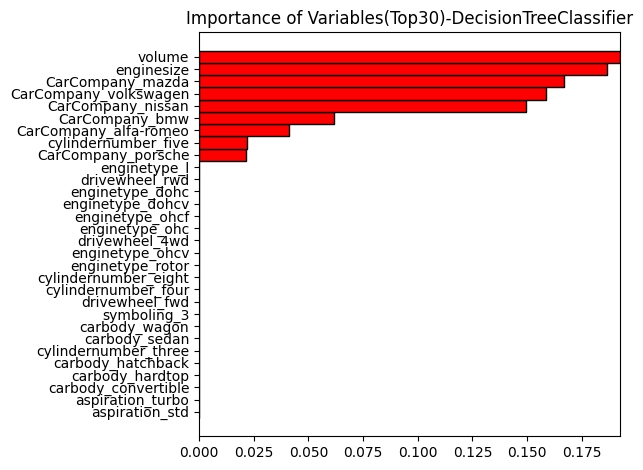

In [62]:
importance_clf=clf.feature_importances_
# feature_names=sig_data.feature_names
feature_names = np.array(std_features.columns)
feature_importance(importance_clf,feature_names,'Importance of Variables(Top30)-DecisionTreeClassifier')
# print(std_features.columns)


### 任务2-2 AdaBoost

In [63]:
from sklearn.ensemble import AdaBoostClassifier
# ada=AdaBoostClassifier(n_estimators=100,random_state=random_state,learning_rate=0.2,
#     algorithm='SAMME.R')
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10
)
ada.fit(X_train,Y_train)
Y_test_pred=ada.predict(X_test)
accuracy_ada=accuracy_score(Y_test,Y_test_pred) *100
print("The test Accuracy: {0:.2f}%".format(accuracy_ada))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)

The test Accuracy: 98.08%


In [64]:
print('准确率 (Accuracy):',accuracy_score(Y_test,Y_test_pred))
print('精确度 (Precision):',precision_score(Y_test, Y_test_pred, average='macro'))
print('召回率 (Recall):',recall_score(Y_test,Y_test_pred, average='macro'))
print('F1分数 (F1 Score):',f1_score(Y_test,Y_test_pred, average='macro'))
print(classification_report(Y_test,Y_test_pred)) 

准确率 (Accuracy): 0.9807692307692307
精确度 (Precision): 0.9861111111111112
召回率 (Recall): 0.9848484848484849
F1分数 (F1 Score): 0.9851558634339436
              precision    recall  f1-score   support

       cheap       0.96      1.00      0.98        23
   expensive       1.00      1.00      1.00         7
    ordinary       1.00      0.95      0.98        22

    accuracy                           0.98        52
   macro avg       0.99      0.98      0.99        52
weighted avg       0.98      0.98      0.98        52



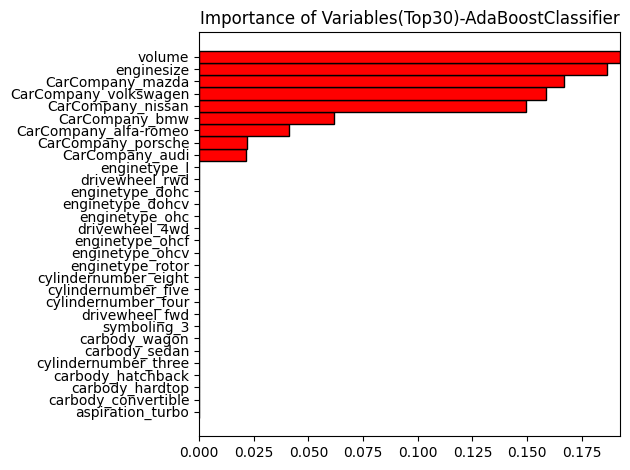

In [65]:
importance_ada=ada.feature_importances_
feature_importance(importance_ada,feature_names,'Importance of Variables(Top30)-AdaBoostClassifier')

### 任务2-3 随机森林

In [66]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=random_state,n_estimators=10)
rf.fit(X_train,Y_train)
Y_test_pred=rf.predict(X_test)
accuracy_rf=accuracy_score(Y_test,Y_test_pred) *100
print("The test Accuracy: {0:.2f}%".format(accuracy_rf))

RandomForestClassifier(n_estimators=10, random_state=1111)

The test Accuracy: 98.08%


In [67]:
print('准确率 (Accuracy):',accuracy_score(Y_test,Y_test_pred))
print('精确度 (Precision):',precision_score(Y_test, Y_test_pred, average='macro'))
print('召回率 (Recall):',recall_score(Y_test,Y_test_pred, average='macro'))
print('F1分数 (F1 Score):',f1_score(Y_test,Y_test_pred, average='macro'))
print(classification_report(Y_test,Y_test_pred)) 

准确率 (Accuracy): 0.9807692307692307
精确度 (Precision): 0.9855072463768115
召回率 (Recall): 0.9855072463768115
F1分数 (F1 Score): 0.9851851851851853
              precision    recall  f1-score   support

       cheap       1.00      0.96      0.98        23
   expensive       1.00      1.00      1.00         7
    ordinary       0.96      1.00      0.98        22

    accuracy                           0.98        52
   macro avg       0.99      0.99      0.99        52
weighted avg       0.98      0.98      0.98        52



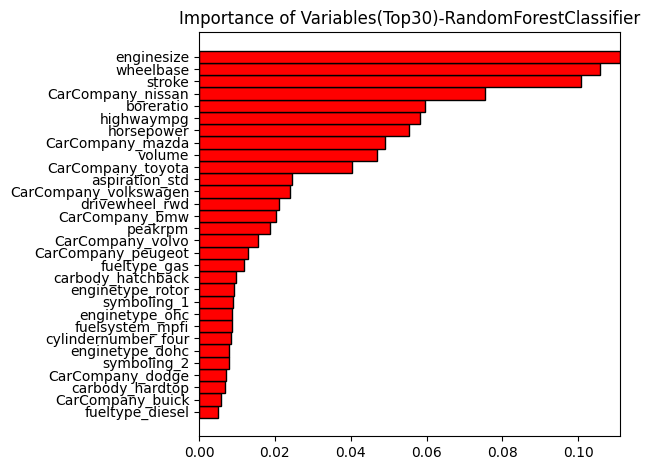

In [68]:
importance_rf=rf.feature_importances_
feature_importance(importance_rf,feature_names,'Importance of Variables(Top30)-RandomForestClassifier')

### 任务2-4 SVM支持向量机

In [69]:
from sklearn.svm import SVC# 导入SVM模型
# 实例化SVM模型，使用线性核
clf=SVC(kernel='rbf')
# 使用训练集训练模型
clf.fit(X_train,Y_train)
# 使用测试集进行预测
Y_test_pred = clf.predict(X_test)
# 计算模型在测试集上的准确率
accuracy_svm=accuracy_score(Y_test,Y_test_pred) *100
# 输出测试集准确率
print("The test accuracy is {:.2f}%".format(accuracy_svm))

SVC()

The test accuracy is 96.15%


In [70]:
print('准确率 (Accuracy):',accuracy_score(Y_test,Y_test_pred))
print('精确度 (Precision):',precision_score(Y_test, Y_test_pred, average='macro'))
print('召回率 (Recall):',recall_score(Y_test,Y_test_pred, average='macro'))
print('F1分数 (F1 Score):',f1_score(Y_test,Y_test_pred, average='macro'))
print(classification_report(Y_test,Y_test_pred))

准确率 (Accuracy): 0.9615384615384616
精确度 (Precision): 0.970959595959596
召回率 (Recall): 0.9372294372294373
F1分数 (F1 Score): 0.952115260625899
              precision    recall  f1-score   support

       cheap       0.96      1.00      0.98        23
   expensive       1.00      0.86      0.92         7
    ordinary       0.95      0.95      0.95        22

    accuracy                           0.96        52
   macro avg       0.97      0.94      0.95        52
weighted avg       0.96      0.96      0.96        52



### 交叉验证与比较

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Text(0.5, 1.0, 'Accuracy of Different Methods')

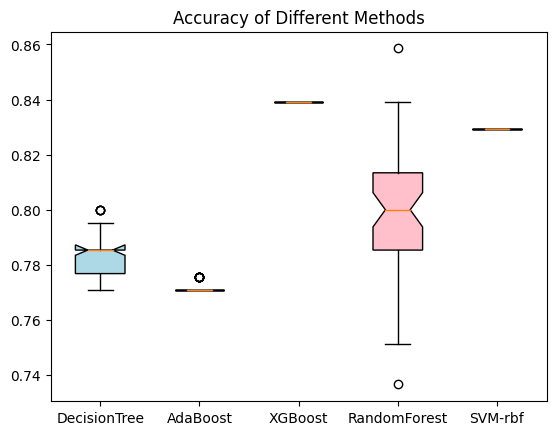

In [71]:
#比较 决策树 AdaBoost XGBoost 随机森林 SVM 算法
#我们对每种算法进行 50 次试验, 每次试验采用 5 折交叉验证计算平均准确率, 
#每次试验中 XGBoost、随机森林和 AdaBoost 都是建立 20 棵决策树的分类器
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
xgb_y = le.fit_transform(Y)
n=50
accuracy_onetree=[]
accuracy_svm=[]
accuracy_rf=[]
accuracy_ada=[]
accuracy_xgb=[]
for i in tqdm(range(n)):
  clf=DecisionTreeClassifier()#决策树
  accuracy_onetree.append(np.mean(cross_val_score(clf,X,Y,scoring='accuracy',cv=5)))
  
  svm = SVC(kernel='rbf',random_state=random_state)
  accuracy_svm.append(np.mean(cross_val_score(svm,X,Y,scoring='accuracy',cv=5)))
  
  rf=RandomForestClassifier(n_estimators=20)
  accuracy_rf.append(np.mean(cross_val_score(rf,X,Y,scoring='accuracy',cv=5)))
  
  ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20),n_estimators=20,learning_rate=0.5)
  accuracy_ada.append(np.mean(cross_val_score(ada,X,Y,scoring='accuracy',cv=5)))

  xgb=XGBClassifier(n_estimators=20,objective='multi:softmax',num_class=3, random_state = random_state)
  accuracy_xgb.append(np.mean(cross_val_score(xgb,X,xgb_y,scoring='accuracy',cv=5)))

fig=plt.figure()
box=plt.boxplot([accuracy_onetree,accuracy_ada,accuracy_xgb,
                 accuracy_rf,accuracy_svm],notch=True,
                patch_artist=True,labels=['DecisionTree','AdaBoost','XGBoost','RandomForest','SVM-rbf'])
colors=['lightblue', 'lightgreen', 'tan', 'pink','lightyellow']
for patch, color in zip(box['boxes'], colors):
  patch.set_facecolor(color)
  patch.set_alpha(1)
plt.title('Accuracy of Different Methods')
plt.show()

In [72]:
#输出 accuracy_X
print("决策树准确率：",accuracy_onetree)
print("Adaboost准确率：",accuracy_ada)
print("XGBoost准确率：",accuracy_xgb)
print("随机森林准确率：",accuracy_rf)
print("SVM准确率：",accuracy_svm)

决策树准确率： [0.7902439024390244, 0.7707317073170732, 0.7902439024390244, 0.7804878048780488, 0.775609756097561, 0.7853658536585366, 0.7902439024390244, 0.7707317073170732, 0.7853658536585366, 0.775609756097561, 0.7804878048780488, 0.7902439024390244, 0.7804878048780488, 0.775609756097561, 0.7853658536585366, 0.775609756097561, 0.7853658536585366, 0.7853658536585366, 0.7804878048780488, 0.8, 0.7853658536585366, 0.7707317073170732, 0.7853658536585366, 0.7853658536585366, 0.8, 0.7853658536585366, 0.8, 0.775609756097561, 0.7804878048780488, 0.7804878048780488, 0.7853658536585366, 0.7804878048780488, 0.775609756097561, 0.7853658536585366, 0.7707317073170732, 0.7853658536585366, 0.775609756097561, 0.8, 0.7853658536585366, 0.7853658536585366, 0.7853658536585366, 0.7853658536585366, 0.7951219512195122, 0.7902439024390244, 0.7853658536585366, 0.775609756097561, 0.7902439024390244, 0.7804878048780488, 0.7804878048780488, 0.775609756097561]
Adaboost准确率： [0.7707317073170732, 0.7707317073170732, 0.7707

In [73]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix


precision_onetree = []
recall_onetree = []
precision_svm = []
recall_svm = []
precision_rf = []
recall_rf = []
precision_ada = []
recall_ada = []
precision_xgb = []
recall_xgb = []

for i in tqdm(range(n)):
    clf = DecisionTreeClassifier()  # 决策树
    y_pred = cross_val_predict(clf, X, Y, cv=5)
    precision_onetree.append(precision_score(Y, y_pred, average='weighted'))
    recall_onetree.append(recall_score(Y, y_pred, average='weighted'))

    svm = SVC(kernel='rbf', random_state=random_state)
    y_pred = cross_val_predict(svm, X, Y, cv=5)
    precision_svm.append(precision_score(Y, y_pred, average='weighted'))
    recall_svm.append(recall_score(Y, y_pred, average='weighted'))

    rf = RandomForestClassifier(n_estimators=20)
    y_pred = cross_val_predict(rf, X, Y, cv=5)
    precision_rf.append(precision_score(Y, y_pred, average='weighted'))
    recall_rf.append(recall_score(Y, y_pred, average='weighted'))

    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=20, learning_rate=0.5)
    y_pred = cross_val_predict(ada, X, Y, cv=5)
    precision_ada.append(precision_score(Y, y_pred, average='weighted'))
    recall_ada.append(recall_score(Y, y_pred, average='weighted'))

    xgb = XGBClassifier(n_estimators=20, objective='multi:softmax', num_class=3, random_state=random_state)
    y_pred = cross_val_predict(xgb, X, xgb_y, cv=5)
    precision_xgb.append(precision_score(xgb_y, y_pred, average='weighted'))
    recall_xgb.append(recall_score(xgb_y, y_pred, average='weighted'))



100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x1b5d4326820>,
 'caps': [<matplotlib.lines.Line2D at 0x1b5d4326d60>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1b5d4326490>,
 'medians': [<matplotlib.lines.Line2D at 0x1b5d43321c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b5d4332460>,
 'means': []}

Text(0.5, 1.0, 'Precision of Different Methods')

{'whiskers': [<matplotlib.lines.Line2D at 0x1b5d436e550>,
 'caps': [<matplotlib.lines.Line2D at 0x1b5d436ea90>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1b5d436e190>,
 'medians': [<matplotlib.lines.Line2D at 0x1b5d436efd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b5d437a2b0>,
 'means': []}

Text(0.5, 1.0, 'Recall of Different Methods')

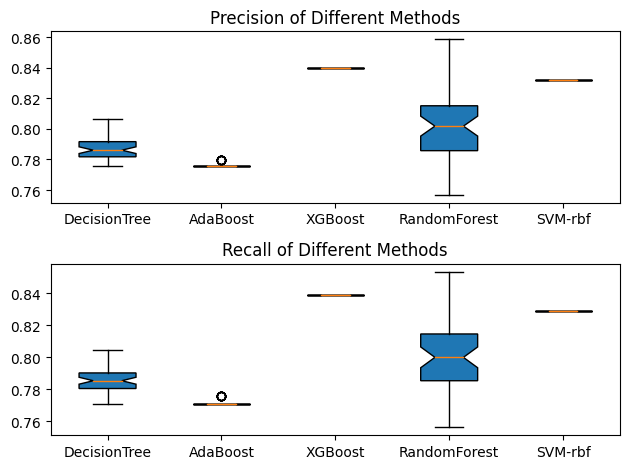

In [74]:
# 在绘制盒图时可以考虑画多个子图，一个子图对应一个性能指标
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()

axes[0].boxplot([precision_onetree, precision_ada, precision_xgb, precision_rf, precision_svm], notch=True,
                patch_artist=True, labels=['DecisionTree', 'AdaBoost', 'XGBoost', 'RandomForest', 'SVM-rbf'])
axes[0].set_title('Precision of Different Methods')

axes[1].boxplot([recall_onetree, recall_ada, recall_xgb, recall_rf, recall_svm], notch=True,
                patch_artist=True, labels=['DecisionTree', 'AdaBoost', 'XGBoost', 'RandomForest', 'SVM-rbf'])
axes[1].set_title('Recall of Different Methods')

plt.tight_layout()
plt.show()

In [75]:
#输出 精确度
print("决策树精确度：",precision_onetree)
print("Adaboost精确度：",precision_ada)
print("XGBoost精确度：",precision_xgb)
print("随机森林精确度：",precision_rf)
print("SVM精确度：",precision_svm)

决策树精确度： [0.7822751188604847, 0.7873985758228983, 0.7859314791294426, 0.7817363530778165, 0.7929455282611102, 0.7817363530778165, 0.787444684573428, 0.8063137487389536, 0.7917937167937167, 0.7817363530778165, 0.7859314791294426, 0.7873985758228983, 0.7822751188604847, 0.7817006340937197, 0.7817363530778165, 0.7822751188604847, 0.787444684573428, 0.7909809702492628, 0.7757119628339141, 0.7817363530778165, 0.7817363530778165, 0.7959385981327844, 0.7873985758228983, 0.7817363530778165, 0.797317844238143, 0.797317844238143, 0.7929455282611102, 0.7822751188604847, 0.7873985758228983, 0.7822751188604847, 0.8010736658558112, 0.7822751188604847, 0.7822751188604847, 0.7817363530778165, 0.7822751188604847, 0.7861978333602816, 0.7817363530778165, 0.7929455282611102, 0.7817363530778165, 0.7822751188604847, 0.8010276505658935, 0.7916343018178487, 0.787444684573428, 0.7916343018178487, 0.7817363530778165, 0.8010736658558112, 0.8010736658558112, 0.7873985758228983, 0.7817363530778165, 0.79111402609824

In [76]:
#输出 召回率
print("决策树召回率：",recall_onetree)
print("Adaboost召回率：",recall_ada)
print("XGBoost召回率：",recall_xgb)
print("随机森林召回率：",recall_rf)
print("SVM召回率：",recall_svm)

决策树召回率： [0.775609756097561, 0.7853658536585366, 0.7853658536585366, 0.7804878048780488, 0.7902439024390244, 0.7804878048780488, 0.7853658536585366, 0.8048780487804879, 0.7853658536585366, 0.7804878048780488, 0.7853658536585366, 0.7853658536585366, 0.775609756097561, 0.775609756097561, 0.7804878048780488, 0.775609756097561, 0.7853658536585366, 0.7902439024390244, 0.7707317073170732, 0.7804878048780488, 0.7804878048780488, 0.7951219512195122, 0.7853658536585366, 0.7804878048780488, 0.7902439024390244, 0.7902439024390244, 0.7902439024390244, 0.775609756097561, 0.7853658536585366, 0.775609756097561, 0.8, 0.775609756097561, 0.775609756097561, 0.7804878048780488, 0.775609756097561, 0.7804878048780488, 0.7804878048780488, 0.7902439024390244, 0.7804878048780488, 0.775609756097561, 0.7951219512195122, 0.7902439024390244, 0.7853658536585366, 0.7902439024390244, 0.7804878048780488, 0.8, 0.8, 0.7853658536585366, 0.7804878048780488, 0.7853658536585366]
Adaboost召回率： [0.7707317073170732, 0.7707317073